In [1]:
import os
import numpy as np 
import os
import nibabel as nib
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import glob

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
file_list = []
for dirname, _, filenames in os.walk('segmentations'):
    for filename in filenames:
      file_list.append((dirname, filename))
        
for dirname, _, filenames in os.walk('volumes'):
    for filename in filenames:
      file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)
print(df_files.head())
print(df_files.tail())

         dirname              filename
0  segmentations    segmentation-0.nii
1  segmentations    segmentation-1.nii
2  segmentations   segmentation-10.nii
3  segmentations  segmentation-100.nii
4  segmentations  segmentation-101.nii
     dirname       filename
257  volumes  volume-95.nii
258  volumes  volume-96.nii
259  volumes  volume-97.nii
260  volumes  volume-98.nii
261  volumes  volume-99.nii


In [6]:
df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = 'segmentations'

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


dirname        filename   mask_dirname         mask_filename
0    volumes    volume-0.nii  segmentations    segmentation-0.nii
1    volumes    volume-1.nii  segmentations    segmentation-1.nii
2    volumes   volume-10.nii  segmentations   segmentation-10.nii
3    volumes  volume-100.nii  segmentations  segmentation-100.nii
4    volumes  volume-101.nii  segmentations  segmentation-101.nii
..       ...             ...            ...                   ...
126  volumes   volume-95.nii  segmentations   segmentation-95.nii
127  volumes   volume-96.nii  segmentations   segmentation-96.nii
128  volumes   volume-97.nii  segmentations   segmentation-97.nii
129  volumes   volume-98.nii  segmentations   segmentation-98.nii
130  volumes   volume-99.nii  segmentations   segmentation-99.nii

[131 rows x 4 columns]

In [7]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)

(512, 512, 75)
(512, 512, 75)


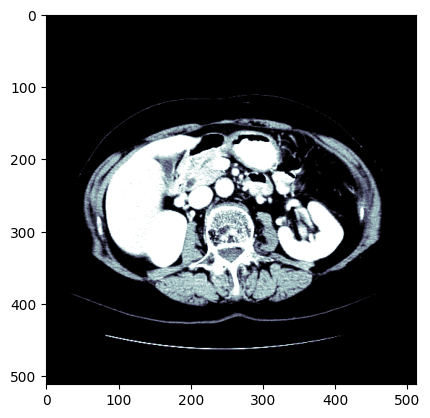

In [9]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [10]:
def plot_sample(array_list, color_map = 'nipy_spectral'):

    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

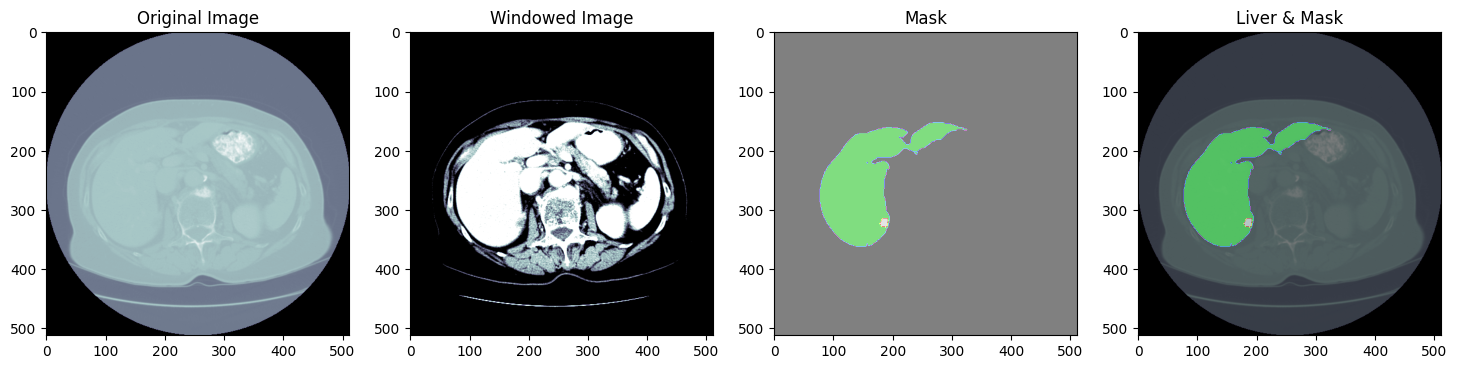

In [11]:
sample=56
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

<Axes: >

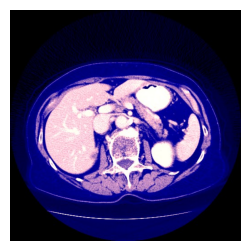

In [12]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

    
#  Функция freqhist_bins разбивает диапазон значений пикселей на группы с примерно одинаковым количеством пикселей
@patch
def freqhist_bins(self:Tensor, n_bins=100):
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
    
#  Функция hist_scaled масштабирует тензор на значения между 0 и 1, используя результат работы freqhist_bins
@patch
def hist_scaled(self:Tensor, brks=None):
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
#  Функция to_nchan преобразует тензор в несколько каналов
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))


#  Функция save_jpg сохраняет изображение в формате JPG, применяя необходимые преобразования (функции freqhist_bins, hist_scaled, to_nchan)
@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)


#  Вывод тестового изображения
sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [13]:
def preprocess_nii(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return np.array(data)

In [ ]:
liver_mask_list = []
tumor_mask_list = []
img_list = []

img_size = (256, 256)

count = 0
skip_next = False

for dir_name, file_name, mask_dir, mask_file in zip(df_files['dirname'], df_files['filename'], df_files['mask_dirname'], df_files['mask_filename']):
    if skip_next:
        skip_next = False
        continue

    index_list = []

    mask_data = preprocess_nii(f"{mask_dir}/{mask_file}")

    for i in range(mask_data.shape[2]):
        slice_data = np.array(mask_data[..., i]) > 0.5
        count += 1

        if slice_data.sum() > 0:
            resized_mask = np.array(Image.fromarray(mask_data[..., i]).resize(img_size))
            liver_mask_list.append(1.0 > (resized_mask < 1.1).astype(bool))
            tumor_mask_list.append((resized_mask.astype(bool)) ^ liver_mask_list[-1])
            index_list.append(i)

        elif count > 10:
            count = 0
            resized_mask = np.array(Image.fromarray(mask_data[..., i]).resize(img_size))
            liver_mask_list.append(1.0 > (resized_mask < 1.1).astype(bool))
            tumor_mask_list.append((resized_mask.astype(bool)) ^ liver_mask_list[-1])
            index_list.append(i)

    img_data = preprocess_nii(f"{dir_name}/{file_name}")

    for ind in index_list:
        img_slice = np.array(Image.fromarray(img_data[..., ind]).resize(img_size))
        img_list.append(img_slice)

    skip_next = True

In [35]:
print("img_list: ", len(img_list), " liver_mask_list: ", len(liver_mask_list), " tumor_mask_list: ", len(tumor_mask_list))

img_list:  11346  liver_mask_list:  11346  tumor_mask_list:  11346


In [36]:
x_train, x_temp, y_train, y_temp = train_test_split(img, np.stack([liver_mask_list, tumor_mask_list, np.logical_and(~np.array(liver_mask_list), ~np.array(tumor_mask_list))], axis=-1), test_size=0.25, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/5, random_state=42)

In [37]:
x_train, y_train, x_valid, y_valid, x_test, y_test = map(np.array, [x_train, y_train, x_valid, y_valid, x_test, y_test])

In [38]:
y_train.shape, x_train.shape

((8509, 256, 256, 3), (8509, 256, 256))

In [39]:
def create_fcn_model(input_shape=(256, 256, 1), target_shape=(256, 256, 3)):
    model = keras.Sequential()

    # Кодировщик
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Декодировщик
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(3, (1, 1), activation='softmax'))  

    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model

In [19]:
from tensorflow.keras import backend as K

class JaccardIndex(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='jaccard_index', **kwargs):
        self.class_id=class_id
        super(JaccardIndex, self).__init__(name=name, **kwargs)
        self.jac = self.add_weight(name='jac', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true[:,:,:,self.class_id], tf.float32)
        y_pred = tf.cast(y_pred[:,:,:,self.class_id], tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
        sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
        jac = (intersection + 100) / (sum_ - intersection + 100)
        self.jac.assign_add(tf.reduce_mean(jac))
        self.count.assign_add(1)

    def result(self):
        return self.jac / tf.cast(self.count, tf.float32)

    def reset_states(self):
        self.jac.assign(0.)
        self.count.assign(0.)

def jaccard_index(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return tf.reduce_mean(jac)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    
    y_true = K.cast(y_true, dtype='float32')
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_final.keras", monitor='val_loss', verbose=1,save_best_only=True, mode='auto')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-10)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

model_final = create_fcn_model()
model_final.save('model_final.keras')
model_final.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=[JaccardIndex(0, name="tumor_jaccard"), JaccardIndex(1, name="liver_jaccard"), Recall(class_id=0, name="tumor_recall"), dice_coefficient])

C:\Users\User\PycharmProjects\liver_segmentation\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history_final = model_final.fit(x_train, y_train, batch_size=16, epochs=30,
                                validation_data=(x_valid, y_valid), callbacks=[reduce_lr,checkpoint])
model_final.save('model_final.keras')

Epoch 1/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coefficient: 0.8871 - liver_jaccard: 0.3772 - loss: 0.2070 - tumor_jaccard: 0.2263 - tumor_recall: 0.0034
Epoch 1: val_loss improved from inf to 0.06575, saving model to model_final.keras
532/532 ━━━━━━━━━━━━━━━━━━━━ 2330s 4s/step - dice_coefficient: 0.8872 - liver_jaccard: 0.3774 - loss: 0.2068 - tumor_jaccard: 0.2265 - tumor_recall: 0.0034 - val_dice_coefficient: 0.9658 - val_liver_jaccard: 0.5720 - val_loss: 0.0657 - val_tumor_jaccard: 0.3266 - val_tumor_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coefficient: 0.9696 - liver_jaccard: 0.5571 - loss: 0.0568 - tumor_jaccard: 0.4404 - tumor_recall: 0.0130
Epoch 2: val_loss improved from 0.06575 to 0.04591, saving model to model_final.keras
532/532 ━━━━━━━━━━━━━━━━━━━━ 2320s 4s/step - dice_coefficient: 0.9697 - liver_jaccard: 0.5572 - loss: 0.0568 - tumor_jaccard: 0.4405 - tumor_recall: 0.0131 - val_dice_coefficient: 0.9780 

In [66]:
def show_history(history_final, train, validation, title):
    plt.plot(history_final.history[train])
    plt.plot(history_final.history[validation])
    plt.title(title)
    plt.ylabel('Значение') 
    plt.xlabel('Эпохи')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

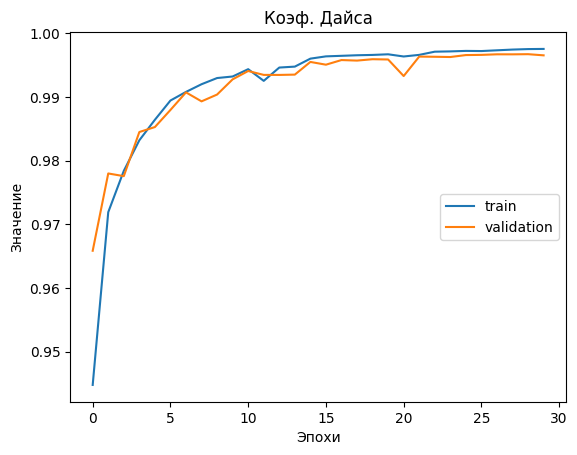

In [71]:
show_history(history_final, 'dice_coefficient', 'val_dice_coefficient', 'Коэф. Дайса')

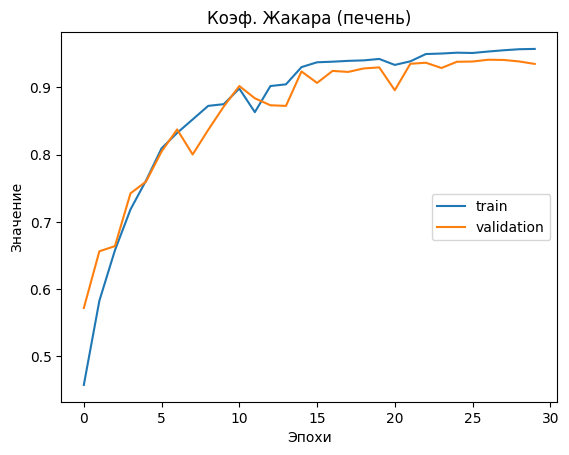

In [72]:
show_history(history_final, 'liver_jaccard', 'val_liver_jaccard', 'Коэф. Жакара (печень)')

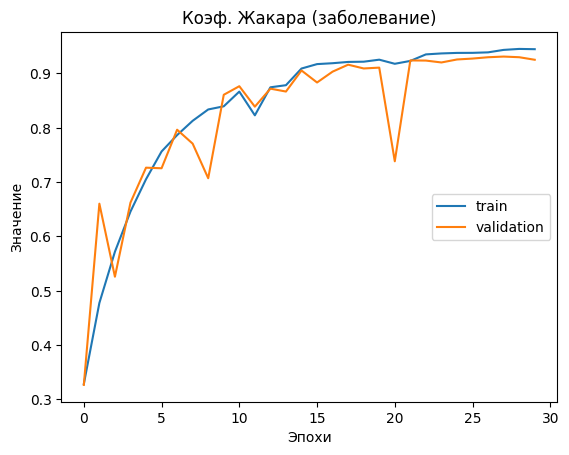

In [73]:
show_history(history_final, 'tumor_jaccard', 'val_tumor_jaccard', 'Коэф. Жакара (заболевание)')

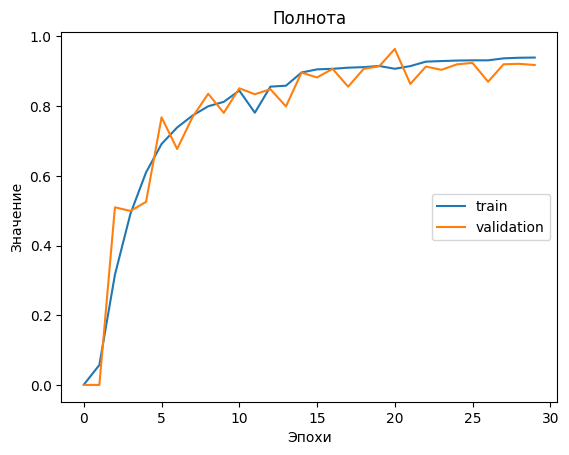

In [74]:
show_history(history_final, 'tumor_recall', 'val_tumor_recall', 'Полнота')

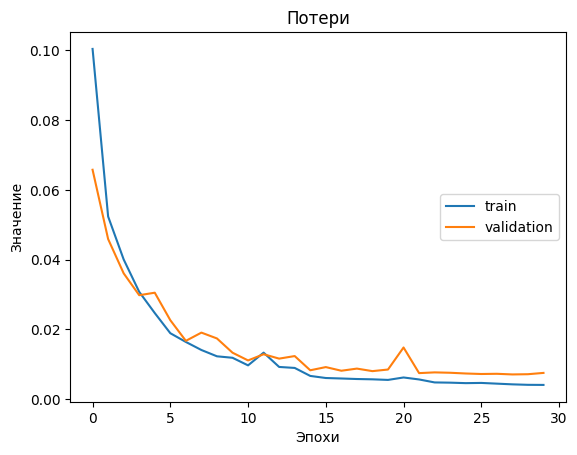

In [75]:
show_history(history_final, 'loss', 'val_loss', 'Потери')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


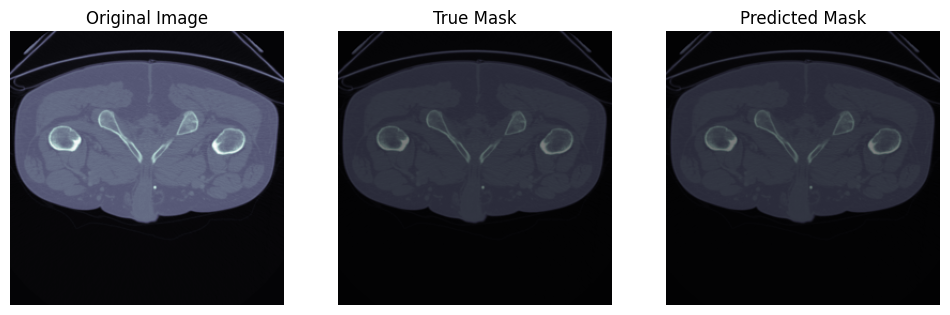

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


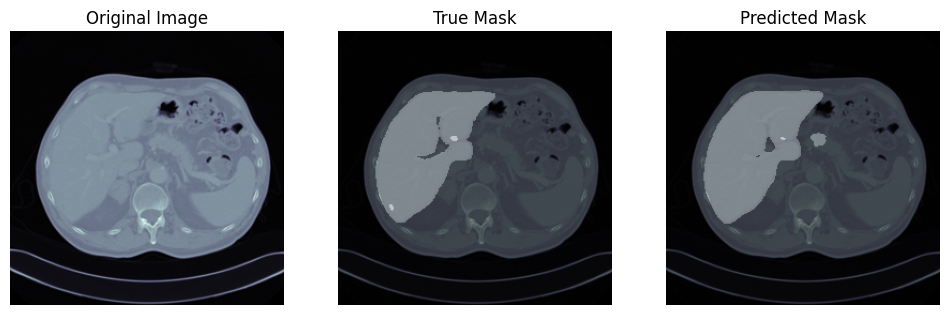

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


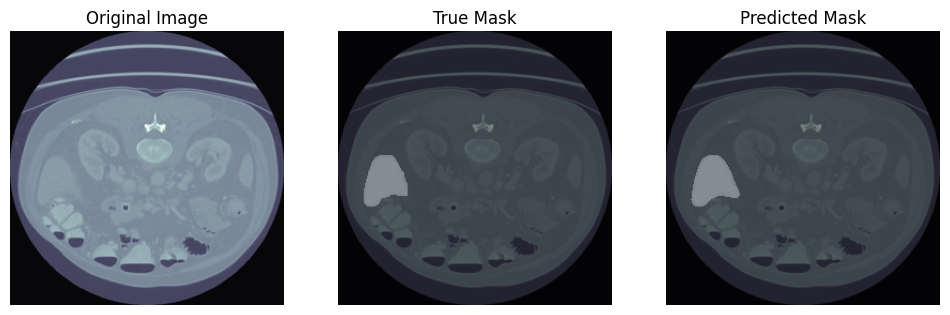

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


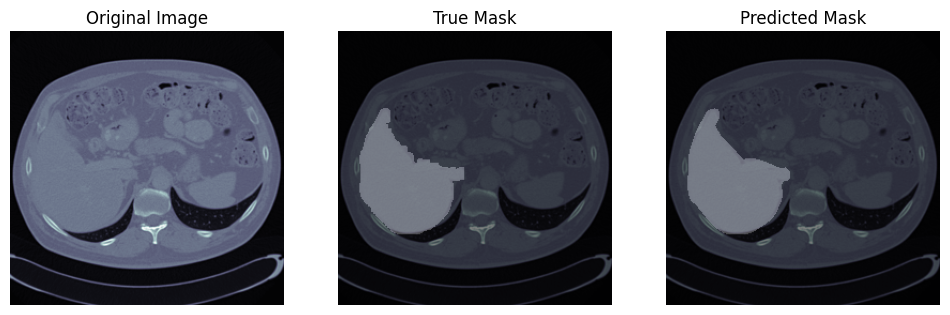

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


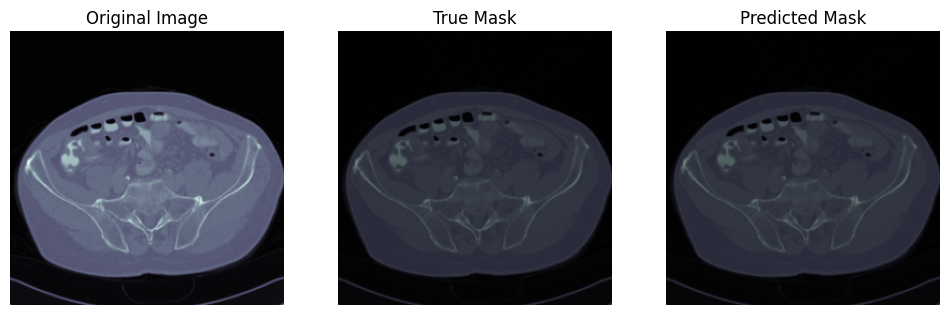

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


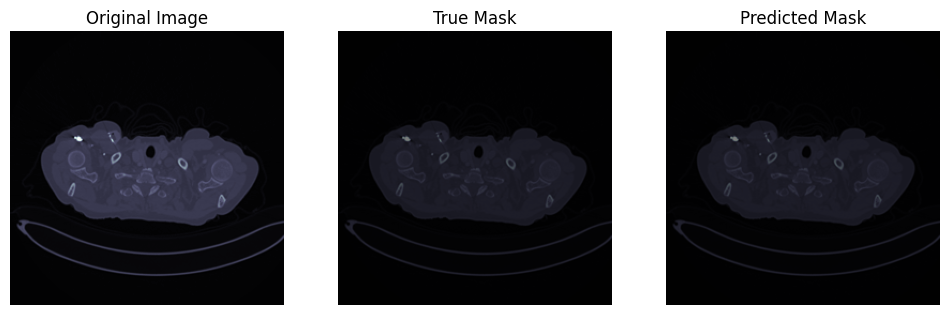

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


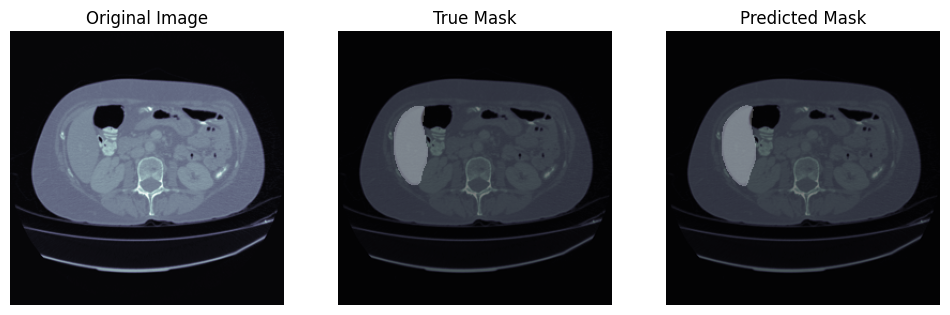

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


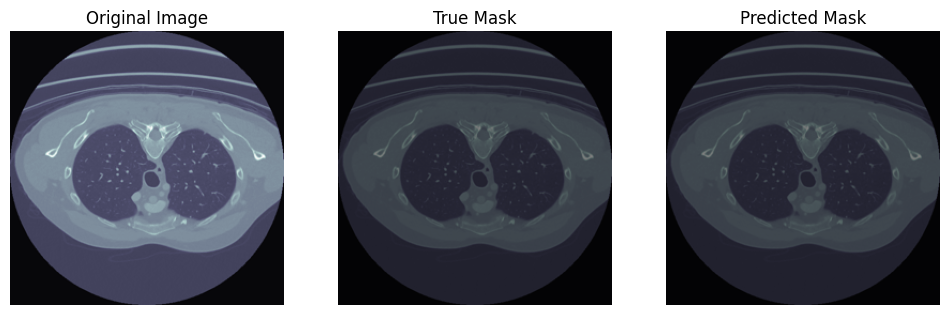

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


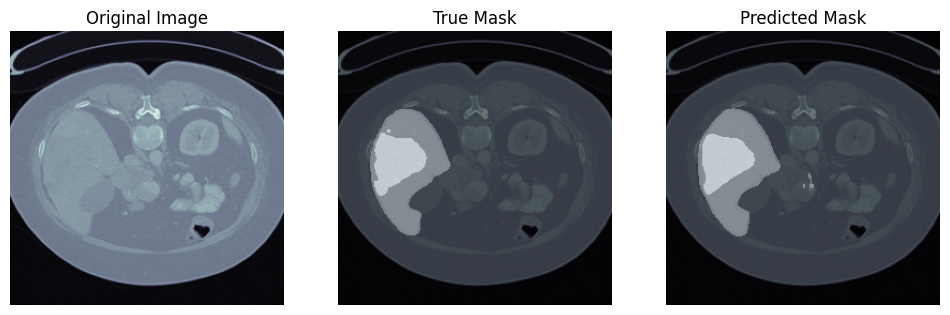

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


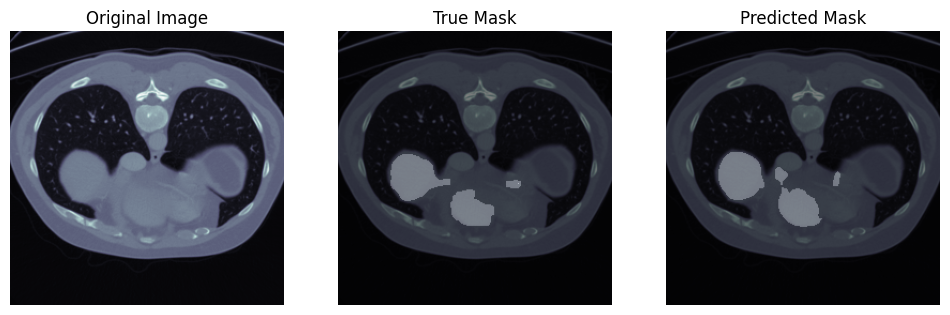

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


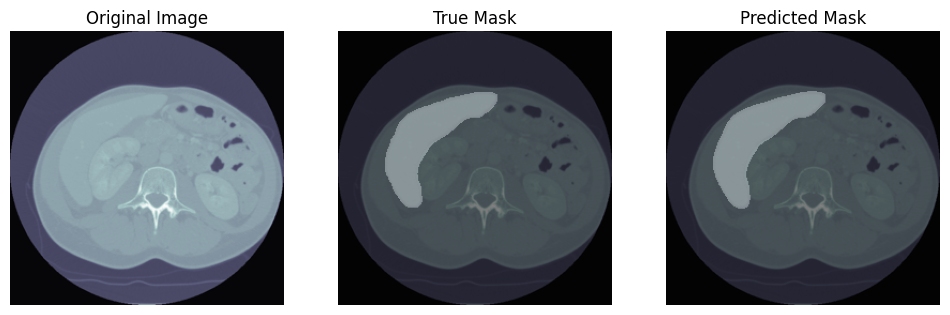

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


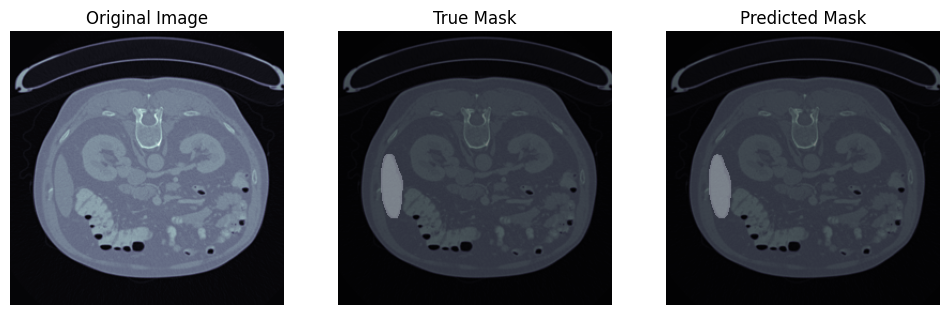

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


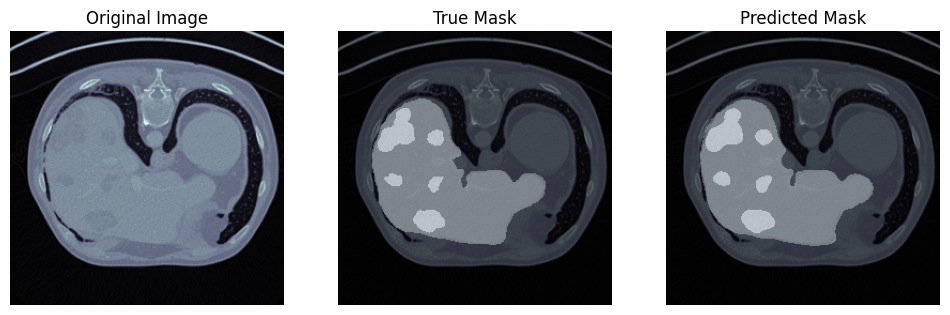

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


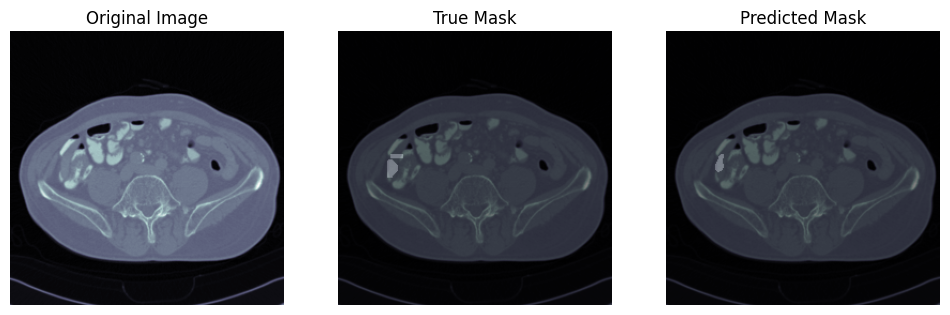

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


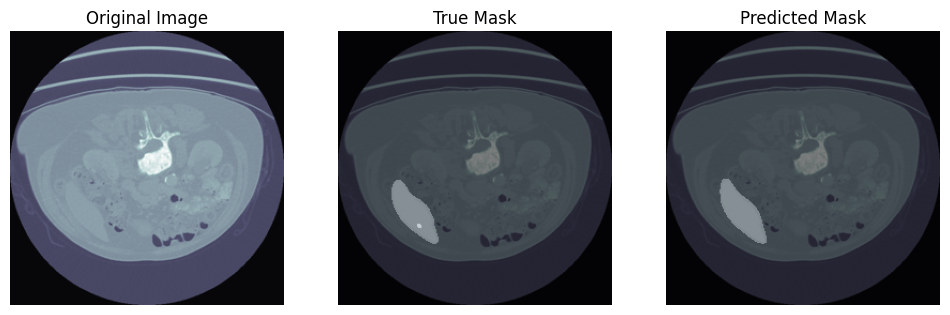

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


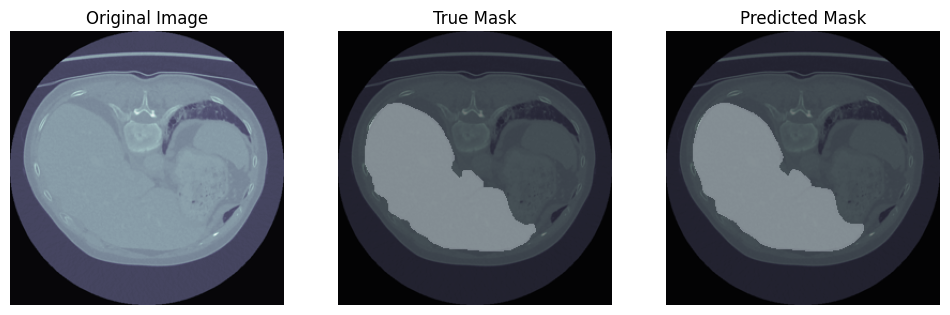

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


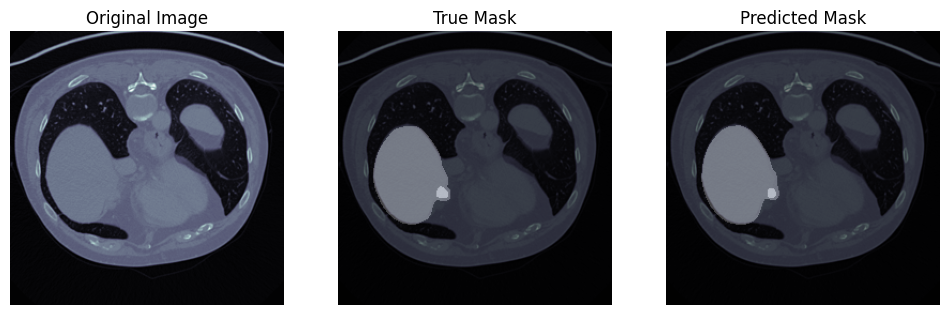

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


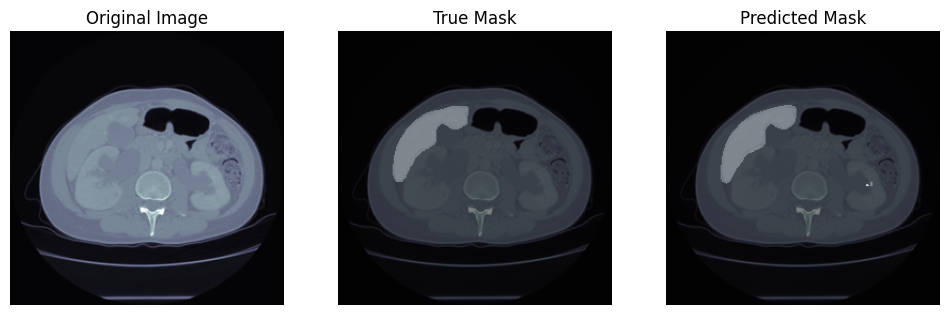

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


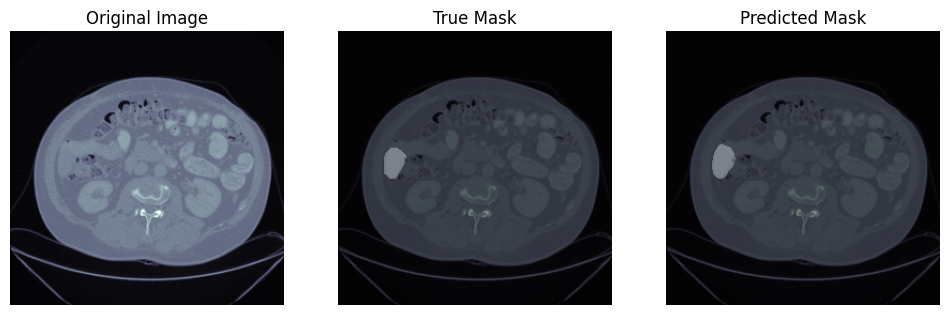

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


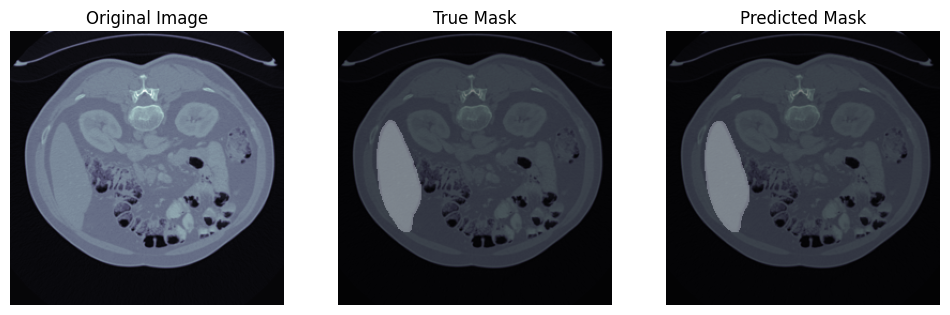

In [65]:
import numpy as np
import random
import matplotlib.pyplot as plt

mask_colors = np.array([[255, 255, 255],
                        [128, 128, 128]])

def rotate_image(image):
    return np.rot90(image)

def show_results(x_test, y_test, color_map = 'nipy_spectral'):
    for i in range(20):
        image_index = random.randint(0, len(x_test) - 1)
        input_image = x_test[image_index]
        true_mask = y_test[image_index]
    
        predicted_mask = model_final.predict(np.expand_dims(input_image, axis=0))[0]
        predicted_mask_binary = (predicted_mask > 0.5)
    
        combined_mask = np.zeros((predicted_mask_binary.shape[0], predicted_mask_binary.shape[1], 3))
        combined_true = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
    
        for class_index in range(2):
            combined_mask[predicted_mask_binary[:, :, class_index]] = mask_colors[class_index]
            combined_true[true_mask[:, :, class_index]] = mask_colors[class_index]
        
        input_image = rotate_image(input_image)
        combined_true = rotate_image(combined_true)
        combined_mask = rotate_image(combined_mask)
    
        plt.figure(figsize=(12, 4))
    
        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='bone')
        plt.title('Original Image')
        plt.axis("off")
    
        plt.subplot(1, 3, 2)
        plt.imshow(input_image, cmap='bone')
        plt.imshow(combined_true.astype(int), alpha=0.5, cmap=color_map)
        plt.title('True Mask')
        plt.axis("off")
    
        plt.subplot(1, 3, 3)
        plt.imshow(input_image, cmap='bone')
        plt.imshow(combined_mask.astype(int), alpha=0.5, cmap=color_map)
        plt.title('Predicted Mask')
        plt.axis("off")
    
        plt.show()

show_results(x_test, y_test)